In [ ]:
# import os, pickle
# import sys
# sys.path.append('/Users/tereza/spring_2025/STAT_4830/STAT-4830-GOALZ-project')
# from config.config import DataConfig
# import sys
# sys.path.insert(0, '/Users/tereza/spring_2025/STAT_4830/STAT-4830-GOALZ-project')
# from config.config import DataConfig

SETUP

In [9]:
import os, pickle

In [10]:
# data_dir = DataConfig.BASE_PATH
# subject_dirs = sorted([d for d in os.listdir(data_dir)
#                        if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])

data_dir = "/Users/tereza/spring_2025/STAT_4830/STAT-4830-GOALZ-project/data/ANPHY-Sleep_data"
# Get all subject folders (e.g. EPCTL01, EPCTL02, ..., EPCTL29)
subject_dirs = sorted([d for d in os.listdir(data_dir)
                       if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])
stages = ["W", "N1", "N2", "N3", "R"]

# Structure: all_data[subject_id][stage] = <data from corresponding pickle file>
all_data = {}

for subject in subject_dirs:
    subj_path = os.path.join(data_dir, subject)
    subject_id = subject.lower()  
    all_data[subject_id] = {}
    print(f"Processing subject: {subject}")
    for stage in stages:
        file_name = f"{subject_id}_{stage}_93.pkl"
        file_path = os.path.join(subj_path, file_name)
        if not os.path.exists(file_path):
            print(f"  File not found: {file_path}")
            continue
        with open(file_path, "rb") as f:
            data = pickle.load(f)
        all_data[subject_id][stage] = data
        print(f"  Loaded {len(data)} windows for stage {stage} from {file_path}")

print("\nSummary of loaded data:")
for subject_id, stage_dict in all_data.items():
    print(f"Subject: {subject_id}")
    for stage in stages:
        count = len(stage_dict[stage]) if stage in stage_dict else 0
        print(f"  Stage {stage}: {count} windows")


Processing subject: EPCTL01
  Loaded 93 windows for stage W from /Users/tereza/spring_2025/STAT_4830/STAT-4830-GOALZ-project/data/ANPHY-Sleep_data/EPCTL01/epctl01_W_93.pkl
  Loaded 93 windows for stage N1 from /Users/tereza/spring_2025/STAT_4830/STAT-4830-GOALZ-project/data/ANPHY-Sleep_data/EPCTL01/epctl01_N1_93.pkl
  Loaded 93 windows for stage N2 from /Users/tereza/spring_2025/STAT_4830/STAT-4830-GOALZ-project/data/ANPHY-Sleep_data/EPCTL01/epctl01_N2_93.pkl
  Loaded 93 windows for stage N3 from /Users/tereza/spring_2025/STAT_4830/STAT-4830-GOALZ-project/data/ANPHY-Sleep_data/EPCTL01/epctl01_N3_93.pkl
  Loaded 93 windows for stage R from /Users/tereza/spring_2025/STAT_4830/STAT-4830-GOALZ-project/data/ANPHY-Sleep_data/EPCTL01/epctl01_R_93.pkl
Processing subject: EPCTL02
  Loaded 93 windows for stage W from /Users/tereza/spring_2025/STAT_4830/STAT-4830-GOALZ-project/data/ANPHY-Sleep_data/EPCTL02/epctl02_W_93.pkl
  Loaded 93 windows for stage N1 from /Users/tereza/spring_2025/STAT_4830/

In [14]:
expected_samples = 400  # 2 seconds at 200 Hz

for subject in subject_dirs:
    subj_path = os.path.join(data_dir, subject)
    subject_id = subject.lower()
    for stage in stages:
        file_name = f"{subject_id}_{stage}_93.pkl"
        file_path = os.path.join(subj_path, file_name)
        if not os.path.exists(file_path):
            continue
        
        with open(file_path, "rb") as f:
            data = pickle.load(f)  # data is assumed to be a pandas DataFrame
        
        for idx, row in data.iterrows():
            # Split on commas to get the list of numeric samples
            samples = row["window"].split(",")
            actual_samples = len(samples)
            
            if actual_samples != expected_samples:
                print(
                    f"Warning: {row['key']} in {file_name} "
                    f"has {actual_samples} samples (expected {expected_samples})."
                )
            # else:
            #     print(f"all good")

UNIVARIATE FEATURE EXTRACTION

In [31]:
from scipy.stats import skew, kurtosis
from scipy.signal import welch
import pandas as pd
import numpy as np

In [41]:
import os
import numpy as np
import pandas as pd
import pywt
import pycatch22 as catch22
from scipy.stats import skew, kurtosis
from scipy.signal import welch

# helper: compute band power
def bandpower(psd, freqs, fmin, fmax):
    idx = np.logical_and(freqs >= fmin, freqs <= fmax)
    return np.trapz(psd[idx], freqs[idx])  # or np.trapezoid(...) to avoid deprecation

# helper: compute spectral entropy
def spectral_entropy(psd):
    psd_sum = np.sum(psd)
    if psd_sum <= 0:
        return 0.0
    psd_norm = psd / psd_sum
    psd_norm = psd_norm[psd_norm > 0]
    return -np.sum(psd_norm * np.log2(psd_norm))

# wavelet-based features
def wavelet_features(signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet=wavelet, level=level)
    feats = {}
    for i, c in enumerate(coeffs):
        c_name = f"wave_coeff{i}"
        feats[f"{c_name}_energy"] = np.sum(c**2)
        feats[f"{c_name}_var"] = np.var(c)
    return feats

# catch22-based features
def catch22_features(signal):
    result = catch22.catch22_all(signal.tolist())
    feats = {}
    for name, val in zip(result['names'], result['values']):
        feats[f"catch22_{name}"] = val
    return feats

# main advanced feature extraction
def extract_advanced_features(signal, sfreq=200):
    # time-domain stats
    x_mean = np.mean(signal)
    x_var = np.var(signal)
    x_skew = skew(signal)
    x_kurt = kurtosis(signal)
    zero_crosses = np.sum(np.diff(np.sign(signal)) != 0)
    zcr = zero_crosses / len(signal)
    
    # welch psd
    freqs, psd = welch(signal, fs=sfreq, nperseg=len(signal))
    delta_power = bandpower(psd, freqs, 0.5, 4)
    theta_power = bandpower(psd, freqs, 4, 8)
    alpha_power = bandpower(psd, freqs, 8, 12)
    beta_power  = bandpower(psd, freqs, 12, 30)
    gamma_power = bandpower(psd, freqs, 30, 45)
    spec_ent = spectral_entropy(psd)
    
    feats = {
        "mean": x_mean,
        "var": x_var,
        "skew": x_skew,
        "kurtosis": x_kurt,
        "zcr": zcr,
        "delta_power": delta_power,
        "theta_power": theta_power,
        "alpha_power": alpha_power,
        "beta_power": beta_power,
        "gamma_power": gamma_power,
        "spectral_entropy": spec_ent,
    }
    
    # add wavelet features
    wave_feats = wavelet_features(signal, wavelet='db4', level=4)
    feats.update(wave_feats)
    
    # add catch22 features
    c22_feats = catch22_features(signal)
    feats.update(c22_feats)
    
    return feats

In [42]:
# extract features, store in dataframe
data_dir = "/Users/tereza/spring_2025/STAT_4830/STAT-4830-GOALZ-project/data/ANPHY-Sleep_data"

subject_dirs = sorted([d for d in os.listdir(data_dir)
                       if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])
stages = ["W", "N1", "N2", "N3", "R"]
all_features = []

for subject in subject_dirs:
    subj_path = os.path.join(data_dir, subject)
    subject_id = subject.lower()
    for stage in stages:
        file_name = f"{subject_id}_{stage}_93.pkl"
        file_path = os.path.join(subj_path, file_name)
        if not os.path.exists(file_path):
            continue
        with open(file_path, "rb") as f:
            data = pickle.load(f)  # assume it's a DataFrame with ['key','subject','stage','electrode','window',...]
        for idx, row in data.iterrows():
            window_str = row["window"]
            if isinstance(window_str, str):
                signal = np.array(window_str.split(","), dtype=float)
            else:
                signal = window_str
            # compute advanced features
            feats_dict = extract_advanced_features(signal, sfreq=200)
            # add identifying info
            feats_dict["subject"] = row["subject"]
            feats_dict["stage"] = row["stage"]
            feats_dict["win_num"] = row["win_num"]
            feats_dict["electrode"] = row["electrode"]
            all_features.append(feats_dict)

features_df = pd.DataFrame(all_features)
# features_df.to_csv("advanced_features.csv", index=False)
print("features shape:", features_df.shape)

# subject_dirs = sorted([d for d in os.listdir(data_dir)
#                        if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])
# stages = ["W","N1","N2","N3","R"]
# all_features = []

# for subject in subject_dirs:
#     subj_path = os.path.join(data_dir, subject)
#     subject_id = subject.lower()
#     for stage in stages:
#         file_name = f"{subject_id}_{stage}_93.pkl"
#         file_path = os.path.join(subj_path, file_name)
#         if not os.path.exists(file_path):
#             continue
#         with open(file_path,"rb") as f:
#             data = pickle.load(f)
#         for idx, row in data.iterrows():
#             window_str = row["window"]
#             if isinstance(window_str, str):
#                 signal = np.array(window_str.split(","), dtype=float)
#             else:
#                 signal = window_str
#             feats = extract_features(signal, sfreq=200)
#             feats["subject"] = row["subject"]
#             feats["stage"] = row["stage"]
#             feats["win_num"] = row["win_num"]
#             feats["electrode"] = row["electrode"]
#             all_features.append(feats)

# features_df = pd.DataFrame(all_features)
# features_df.to_csv("all_extracted_features.csv", index=False)

/var/folders/g6/qyrrm6017k55qbd8_wywqxgw0000gn/T/ipykernel_27568/3450744228.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[idx], freqs[idx])  # or np.trapezoid(...) to avoid deprecation
/var/folders/g6/qyrrm6017k55qbd8_wywqxgw0000gn/T/ipykernel_27568/3450744228.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[idx], freqs[idx])  # or np.trapezoid(...) to avoid deprecation
/var/folders/g6/qyrrm6017k55qbd8_wywqxgw0000gn/T/ipykernel_27568/3450744228.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[idx], freqs[idx])  # or np.trapezoid(...) to avoid deprecation
/var/folders/g6/qyrrm6017k55qbd8_wywqxgw0000gn/T/ipykernel_27568/3450744228.py:12: Depre

features shape: (13485, 47)


CLASSIFICATION

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize, PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

In [43]:
# split subjects into 70% train and 30% test to avoid leakage across windows
unique_subjects = features_df["subject"].unique()
np.random.shuffle(unique_subjects)
train_count = int(0.7 * len(unique_subjects))
train_subjects = unique_subjects[:train_count]
test_subjects = unique_subjects[train_count:]

train_df = features_df[features_df["subject"].isin(train_subjects)].copy()
test_df = features_df[features_df["subject"].isin(test_subjects)].copy()

X_train = train_df.drop(["subject", "stage", "win_num", "electrode"], axis=1)
y_train = train_df["stage"]

X_test = test_df.drop(["subject", "stage", "win_num", "electrode"], axis=1)
y_test = test_df["stage"]

# create groups for group cv (subject-level grouping)
groups_train = train_df["subject"].values

XGBOOST

In [47]:
# block 3: label encoding for y
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
print("class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

class mapping: {'N1': np.int64(0), 'N2': np.int64(1), 'N3': np.int64(2), 'R': np.int64(3), 'W': np.int64(4)}


In [49]:
# block 4: pipeline, parameter grid, and grid search
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    # ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
    ('xgb', XGBClassifier(eval_metric='mlogloss', random_state=42))
])

param_grid = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 6, 10],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.8, 1.0],
}

gkf = GroupKFold(n_splits=5)
grid = GridSearchCV(pipeline, param_grid, cv=gkf, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train_enc, groups=groups_train)

print("best parameters:", grid.best_params_)
print("best cv accuracy:", grid.best_score_)

best parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 1.0}
best cv accuracy: 0.44000000000000006


test accuracy: 0.541457586618877
classification report:
              precision    recall  f1-score   support

          N1       0.35      0.23      0.28       837
          N2       0.49      0.40      0.44       837
          N3       0.63      0.70      0.66       837
           R       0.47      0.51      0.49       837
           W       0.64      0.86      0.74       837

    accuracy                           0.54      4185
   macro avg       0.52      0.54      0.52      4185
weighted avg       0.52      0.54      0.52      4185



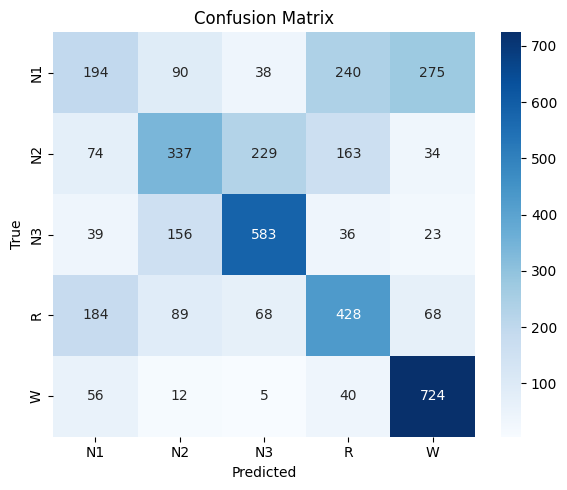

In [50]:
# block 5: evaluation on test set
best_model = grid.best_estimator_
test_acc = best_model.score(X_test, y_test_enc)
print("test accuracy:", test_acc)
print("classification report:")
print(classification_report(y_test_enc, best_model.predict(X_test), target_names=le.classes_))

cm_labels = sorted(le.classes_)
cm = confusion_matrix(y_test_enc, best_model.predict(X_test), labels=range(len(cm_labels)))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=cm_labels, yticklabels=cm_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

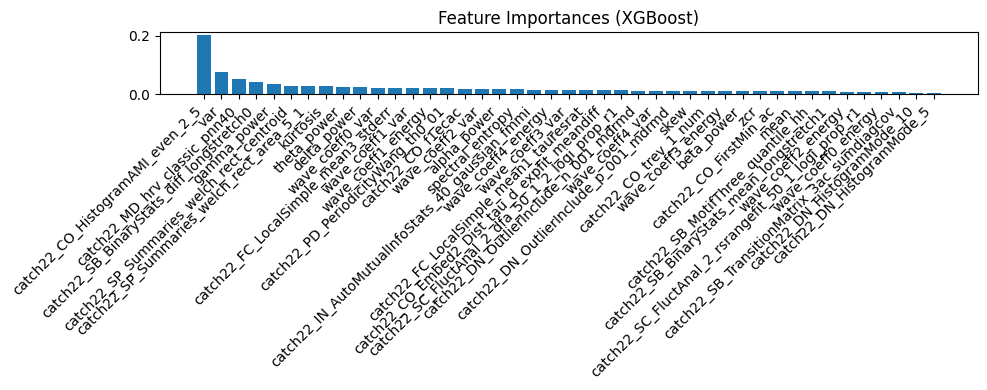

top 10 features by importance:
catch22_CO_HistogramAMI_even_2_5: 0.2013
var: 0.0754
catch22_MD_hrv_classic_pnn40: 0.0523
catch22_SB_BinaryStats_diff_longstretch0: 0.0433
gamma_power: 0.0338
catch22_SP_Summaries_welch_rect_centroid: 0.0301
catch22_SP_Summaries_welch_rect_area_5_1: 0.0288
kurtosis: 0.0285
theta_power: 0.0254
delta_power: 0.0249


In [51]:
# block: plot feature importances from the best xgboost model
xgb_step = best_model.named_steps['xgb']
importances = xgb_step.feature_importances_
feature_names = X_train.columns
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10,4))
plt.bar(range(len(importances)), importances[idx], align='center')
plt.xticks(range(len(importances)), feature_names[idx], rotation=45, ha='right')
plt.title("Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

# print top 10 features
print("top 10 features by importance:")
for i in idx[:10]:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

In [52]:
# extract feature importances from the best xgboost model in the pipeline
importances = best_model.named_steps['xgb'].feature_importances_
feature_names = np.array(X_train.columns)
sorted_idx = np.argsort(importances)[::-1]  # indices from most to least important
sorted_features = feature_names[sorted_idx]

# print top 10 most useful features
print("Top 10 most useful features:")
for feat, imp in zip(sorted_features[:10], importances[sorted_idx][:10]):
    print(f"{feat}: {imp:.4f}")

# print 10 least useful features
least_useful = feature_names[np.argsort(importances)]
print("\n10 Least useful features:")
for feat, imp in zip(least_useful[:10], np.sort(importances)[:10]):
    print(f"{feat}: {imp:.4f}")

Top 10 most useful features:
catch22_CO_HistogramAMI_even_2_5: 0.2013
var: 0.0754
catch22_MD_hrv_classic_pnn40: 0.0523
catch22_SB_BinaryStats_diff_longstretch0: 0.0433
gamma_power: 0.0338
catch22_SP_Summaries_welch_rect_centroid: 0.0301
catch22_SP_Summaries_welch_rect_area_5_1: 0.0288
kurtosis: 0.0285
theta_power: 0.0254
delta_power: 0.0249

10 Least useful features:
catch22_DN_HistogramMode_5: 0.0036
catch22_DN_HistogramMode_10: 0.0043
catch22_SB_TransitionMatrix_3ac_sumdiagcov: 0.0078
wave_coeff0_energy: 0.0086
catch22_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1: 0.0097
wave_coeff2_energy: 0.0098
catch22_SB_BinaryStats_mean_longstretch1: 0.0103
catch22_SB_MotifThree_quantile_hh: 0.0106
mean: 0.0109
catch22_CO_FirstMin_ac: 0.0115


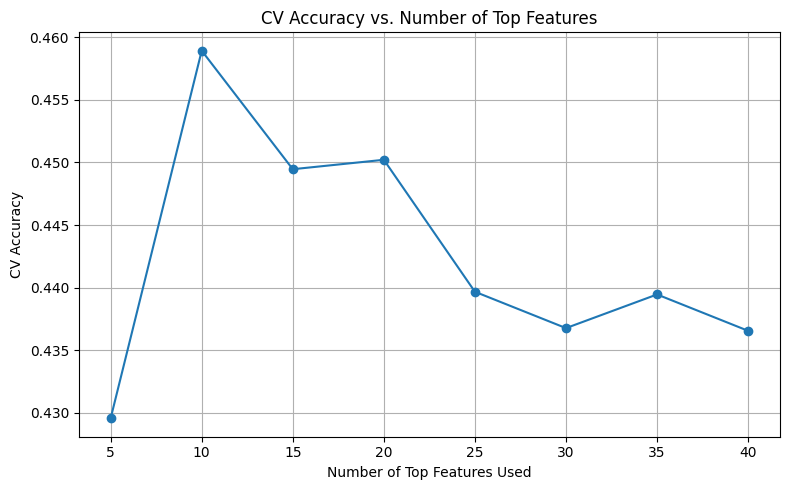

Best number of features: 10 with CV accuracy: 0.45892473118279564


In [53]:
from sklearn.model_selection import cross_val_score

# extract the best xgboost parameters from grid.best_params_
# the parameters in grid.best_params_ are prefixed with 'xgb__'
xgb_params = {k.replace("xgb__", ""): v for k, v in grid.best_params_.items()}

# define a function to evaluate performance using only the top n features
def evaluate_subset(n):
    top_n_features = sorted_features[:n]
    X_train_subset = X_train[top_n_features]
    # build a simple pipeline with scaler and xgb classifier (with fixed parameters)
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', XGBClassifier(**xgb_params, eval_metric='mlogloss', random_state=42))
    ])
    # evaluate using group cross-validation
    scores = cross_val_score(model, X_train_subset, y_train_enc,
                             cv=GroupKFold(n_splits=5),
                             groups=groups_train,
                             scoring='accuracy',
                             n_jobs=-1)
    return np.mean(scores)

# define a range of number of features to test (for example, in steps of 5)
n_features_list = range(5, X_train.shape[1] + 1, 5)
cv_scores = [evaluate_subset(n) for n in n_features_list]

plt.figure(figsize=(8,5))
plt.plot(n_features_list, cv_scores, marker='o')
plt.xlabel("Number of Top Features Used")
plt.ylabel("CV Accuracy")
plt.title("CV Accuracy vs. Number of Top Features")
plt.grid(True)
plt.tight_layout()
plt.show()

# find the number of features that gives the best CV score
best_n = n_features_list[np.argmax(cv_scores)]
print("Best number of features:", best_n, "with CV accuracy:", np.max(cv_scores))

Test Accuracy (Top 10 Features): 0.54026284348865
Classification Report (Top 10 Features):
              precision    recall  f1-score   support

          N1       0.34      0.19      0.24       837
          N2       0.47      0.40      0.43       837
          N3       0.64      0.71      0.67       837
           R       0.49      0.51      0.50       837
           W       0.62      0.89      0.73       837

    accuracy                           0.54      4185
   macro avg       0.51      0.54      0.52      4185
weighted avg       0.51      0.54      0.52      4185



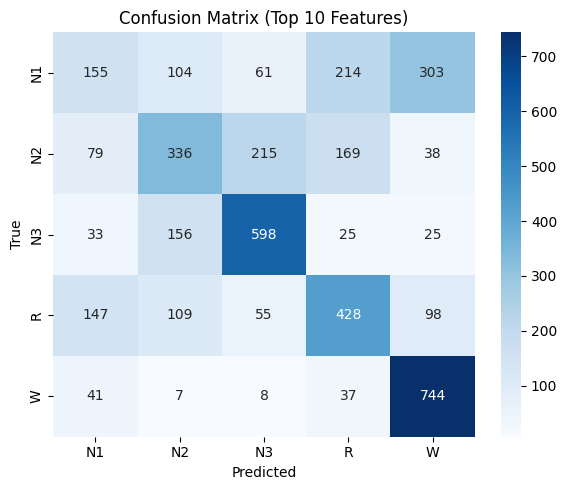

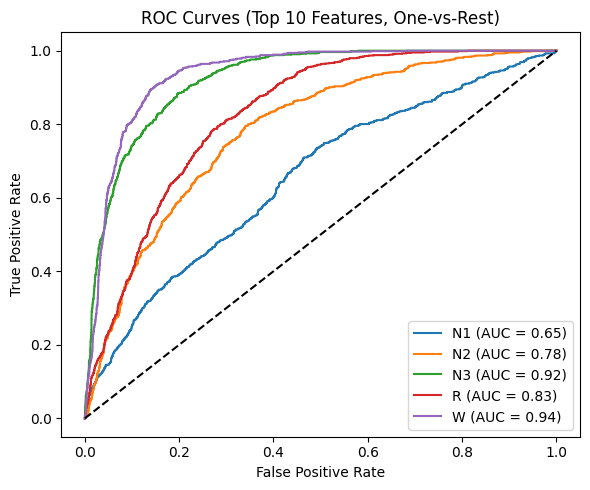

In [54]:
# run model on top 10 features, evaluate performance, and plot roc curves

# select top 10 features
top10_features = sorted_features[:10]
X_train_top10 = X_train[top10_features]
X_test_top10 = X_test[top10_features]

# use best parameters from previous grid search (if available)
# these parameters were stored with keys prefixed by 'xgb__'
best_params = grid.best_params_
xgb_params = {k.replace("xgb__", ""): v for k, v in best_params.items()}

# build a pipeline with scaler and xgboost using the best parameters
pipeline_top10 = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(eval_metric='mlogloss', random_state=42, **xgb_params))
])

# fit on training data
pipeline_top10.fit(X_train_top10, y_train_enc)

# evaluate on test set
test_acc_top10 = pipeline_top10.score(X_test_top10, y_test_enc)
print("Test Accuracy (Top 10 Features):", test_acc_top10)

# print classification report for per-class performance
from sklearn.metrics import classification_report
y_pred_top10 = pipeline_top10.predict(X_test_top10)
print("Classification Report (Top 10 Features):")
print(classification_report(y_test_enc, y_pred_top10, target_names=le.classes_))

# plot confusion matrix
from sklearn.metrics import confusion_matrix
cm_top10 = confusion_matrix(y_test_enc, y_pred_top10, labels=range(len(le.classes_)))
plt.figure(figsize=(6,5))
sns.heatmap(cm_top10, annot=True, fmt='d', cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (Top 10 Features)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# plot roc curves (one-vs-all)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

classes = sorted(le.classes_)
y_test_bin_top10 = label_binarize(y_test_enc, classes=range(len(classes)))
y_score_top10 = pipeline_top10.predict_proba(X_test_top10)

plt.figure(figsize=(6,5))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin_top10[:, i], y_score_top10[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Top 10 Features, One-vs-Rest)")
plt.legend()
plt.tight_layout()
plt.show()

RANDOM FOREST

In [34]:
# block 4: pipeline with polynomial features, scaling, and random forest; then perform grid search
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    # tune polynomial degree as well
    'poly__degree': [1, 2]
}

gkf = GroupKFold(n_splits=5)
grid = GridSearchCV(pipeline, param_grid, cv=gkf, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train, groups=groups_train)

print("best parameters:", grid.best_params_)
print("best cv accuracy:", grid.best_score_)

best parameters: {'poly__degree': 2, 'rf__max_depth': 10, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}
best cv accuracy: 0.440752688172043


In [35]:
# block 5: evaluate the best model on the test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
test_acc = best_model.score(X_test, y_test)
print("test accuracy:", test_acc)
print("classification report:")
print(classification_report(y_test, y_pred))

test accuracy: 0.4824372759856631
classification report:
              precision    recall  f1-score   support

          N1       0.18      0.09      0.12       837
          N2       0.52      0.42      0.46       837
          N3       0.60      0.72      0.66       837
           R       0.44      0.42      0.43       837
           W       0.50      0.76      0.60       837

    accuracy                           0.48      4185
   macro avg       0.45      0.48      0.45      4185
weighted avg       0.45      0.48      0.45      4185



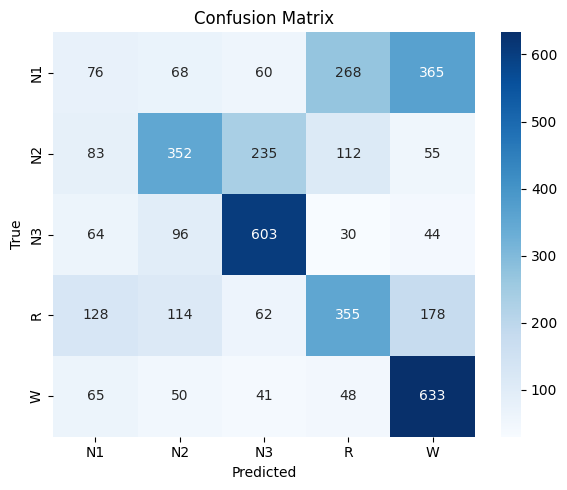

In [36]:
# block 6: plot the confusion matrix
cm_labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, y_pred, labels=cm_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=cm_labels, yticklabels=cm_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [26]:
# # block 5: final training and evaluation on test set
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# test_acc = model.score(X_test, y_test)
# print("test accuracy:", test_acc)

# print("classification report:")
# print(classification_report(y_test, y_pred))

test accuracy: 0.41839904420549584
classification report:
              precision    recall  f1-score   support

          N1       0.16      0.15      0.16       837
          N2       0.36      0.37      0.36       837
          N3       0.59      0.66      0.63       837
           R       0.34      0.38      0.36       837
           W       0.65      0.53      0.58       837

    accuracy                           0.42      4185
   macro avg       0.42      0.42      0.42      4185
weighted avg       0.42      0.42      0.42      4185



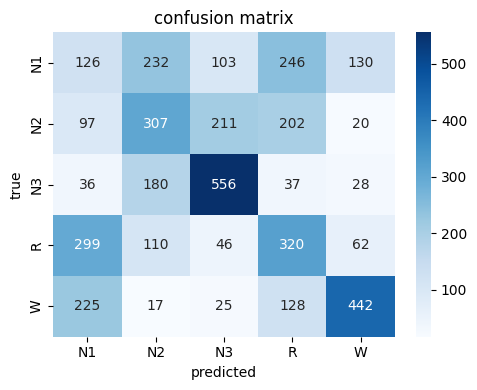

In [27]:
# # block 6: confusion matrix
# cm_labels = sorted(y_test.unique())  # e.g. ["N1","N2","N3","R","W"] or any order
# cm = confusion_matrix(y_test, y_pred, labels=cm_labels)

# plt.figure(figsize=(5,4))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=cm_labels, yticklabels=cm_labels)
# plt.title("confusion matrix")
# plt.xlabel("predicted")
# plt.ylabel("true")
# plt.tight_layout()
# plt.show()

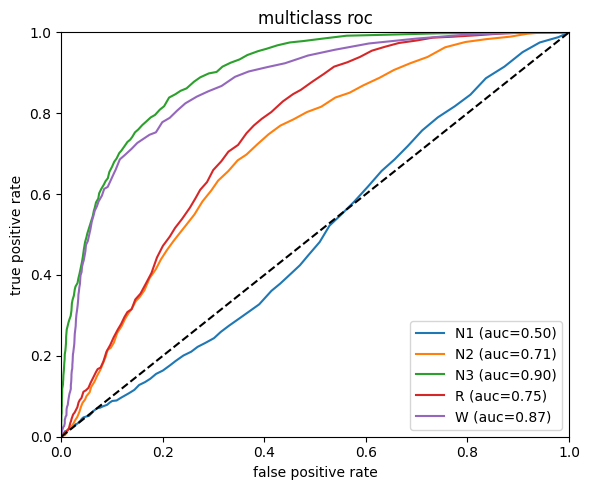

In [28]:
# # block 7: roc curves (one-vs-all approach)
# classes = sorted(y_test.unique())
# y_test_bin = label_binarize(y_test, classes=classes)
# y_score = model.predict_proba(X_test)

# plt.figure(figsize=(6,5))
# for i, c in enumerate(classes):
#     fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label=f"{c} (auc={roc_auc:.2f})")

# plt.plot([0,1],[0,1],"k--")
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.xlabel("false positive rate")
# plt.ylabel("true positive rate")
# plt.title("multiclass roc")
# plt.legend()
# plt.tight_layout()
# plt.show()

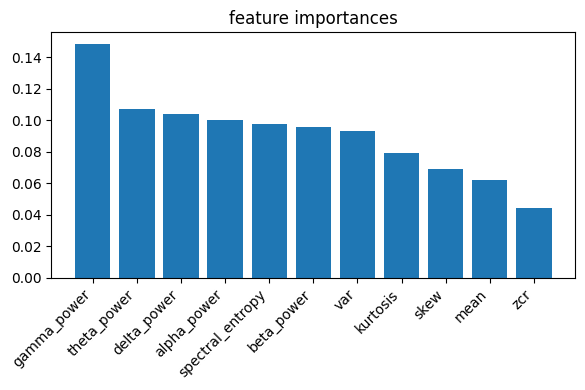

In [29]:
# # block 8: feature importances
# importances = model.feature_importances_
# feature_names = X_train.columns
# idx = np.argsort(importances)[::-1]

# plt.figure(figsize=(6,4))
# plt.bar(range(len(importances)), importances[idx], align="center")
# plt.xticks(range(len(importances)), feature_names[idx], rotation=45, ha="right")
# plt.title("feature importances")
# plt.tight_layout()
# plt.show()

1D CNN

In [39]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# block 2: reshape your data
# assume you have something like X of shape (n_samples, n_channels, n_times),
# and y is the class label for each sample (string or integer).
# also assume you have subject_ids array for grouping

# example placeholders:
# X.shape -> (N, 93, 400)
# y.shape -> (N,)
# subject_ids.shape -> (N,)

# block 3: subject-based split
unique_subj = np.unique(subject_ids)
np.random.shuffle(unique_subj)
train_count = int(0.7 * len(unique_subj))
train_subj = unique_subj[:train_count]
test_subj  = unique_subj[train_count:]

train_mask = np.isin(subject_ids, train_subj)
test_mask  = np.isin(subject_ids, test_subj)

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

# optionally encode y as integers 0..4
class_names = np.unique(y_train)
class_to_idx = {c: i for i, c in enumerate(class_names)}
y_train_enc = np.array([class_to_idx[c] for c in y_train])
y_test_enc = np.array([class_to_idx[c] for c in y_test])

# block 4: build a 1D cnn model
# for example, we can treat n_channels as "channels" dimension and n_times as "length"
# or vice versa. here we'll do a 1D convolution across time, with n_channels as separate input channels
# so we reshape X to (samples, time, channels) or (samples, channels, time). Keras typically expects (samples, length, channels)
# so let's reorder to (N, 400, 93) if needed

X_train_reshaped = np.transpose(X_train, (0, 2, 1))  # shape: (N, 400, 93)
X_test_reshaped  = np.transpose(X_test,  (0, 2, 1))

num_classes = len(class_names)

model = models.Sequential()
model.add(layers.Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(400, 93)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# block 5: train the cnn
history = model.fit(X_train_reshaped, y_train_enc, 
                    validation_split=0.2, 
                    epochs=10, 
                    batch_size=32)

# block 6: evaluate on test set
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test_enc)
print("test accuracy:", test_acc)

y_pred_enc = np.argmax(model.predict(X_test_reshaped), axis=1)
print("classification report:")
print(classification_report(y_test_enc, y_pred_enc, target_names=class_names))

# block 7: confusion matrix
cm = confusion_matrix(y_test_enc, y_pred_enc)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'tensorflow'